# <center>Machine Learning Project</center>

** **
## <center>*02 - Feature Selection*</center>

** **

The members of the `team` are:
- Ana Farinha - 20211514
- Francisco Capontes - 20211692
- Sofia Gomes - 20240848
- Rui Lourenço - 2021639

## <span style="color:salmon"> Table of Contents </span>

<a class="anchor" id="top"></a>


1. [Filter Methods](#1-filter-methods)<br>  
    1.1 [Univariate Variables](#11-univariate-variables)<br>  
    1.2 [Correlation Indices](#12-correlation-indices)<br>    
    1.3 [Chi-Squared](#13-chi-squared)<br><br>     
2. [Wrapper Methods](#2-wrapper-methods)<br>    
    2.1 [Logistic Regression](#21-logistic-regression)<br>    
    2.2 [Support Vector Machine](#22-support-vector-machine)<br><br>      
3. [Embedded Methods](#3-embedded-methods)<br>     
    3.1 [LassoCV](#31-lassocv)<br>  



In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Sklearn packages
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score
from sklearn.feature_selection import mutual_info_classif

# Models
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# embedded methods
from sklearn.linear_model import LassoCV
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.feature_selection import RFE

import warnings
warnings.filterwarnings('ignore')

from utils import *
from utils_feature_selection import *
from utils_dicts import numerical_features, categorical_features

%load_ext autoreload
%autoreload 2

In [2]:
try:
    import torch
    import ray
except:
    !pip install torch # remove when requirements are updated
    import torch
    import ray
device_xgb = "cuda" if torch.cuda.is_available() else "cpu"
device_lgb = "gpu" if torch.cuda.is_available() else "cpu"

# No train temos de input:
- Average Weekly Wage
- Age at Injury

- Based on the new Age at Injury calcular o Birth Year

*Input `Birth Year`*

In [3]:
# Import dataset
train_df = pd.read_csv('preprocessed_data/train_data.csv', index_col="Claim Identifier")
test_df =  pd.read_csv('preprocessed_data/test_data.csv', index_col="Claim Identifier")

In [4]:
missing_percentage = train_df.isna().sum() / len(train_df) * 100
for col, percent in missing_percentage.items():
    if not percent == 0:
        print(f"{col}: {percent:.2f}% missing values")

Age at Injury: 0.40% missing values
Average Weekly Wage: 63.43% missing values
Birth Year: 0.40% missing values
Industry Code: 1.73% missing values
WCIO Cause of Injury Code: 2.72% missing values
WCIO Nature of Injury Code: 2.73% missing values
WCIO Part Of Body Code: 2.98% missing values
Zip Code: 4.99% missing values


In [5]:
for col in train_df.columns:
    if not (col in numerical_features or col in categorical_features):
        print(f"'{col}',")

'Accident Date',
'County of Injury',
'District Name',
'Industry Code',
'WCIO Cause of Injury Code',
'WCIO Nature of Injury Code',
'WCIO Part Of Body Code',
'Zip Code',
'Claim Injury Type Encoded',


In [6]:
for col in numerical_features+categorical_features:
    if col not in train_df.columns:
        print(f"'{col}',")

'Enc County of Injury',
'Enc District Name',
'Enc Industry Code',
'Enc WCIO Cause of Injury Code',
'Enc WCIO Nature of Injury Code',
'Enc WCIO Part Of Body Code',
'Enc Zip Code',
'Relative_Wage',
'Financial Impact Category',
'Age_Group',


In [7]:
X = train_df.drop(["Claim Injury Type Encoded"], axis = 1)
y = train_df["Claim Injury Type Encoded"]

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.25, stratify = y, shuffle = True)

In [9]:
X_train, X_val = apply_frequency_encoding(X_train,X_val)

In [10]:
for col in X_train.columns:
    if not (col in numerical_features or col in categorical_features):
        print(f"'{col}',")

'Accident Date',


In [11]:
for col in numerical_features+categorical_features:
    if col not in X_train.columns:
        print(f"'{col}',")

'Relative_Wage',
'Financial Impact Category',
'Age_Group',


# Input Age at Injury, Birth Year and Average Weekly Wage

In [12]:
to_impute = ["Age at Injury","Average Weekly Wage"]
imputation_value  = X_train[to_impute].median()
for col in to_impute:
        X_train[col].fillna(imputation_value[col], inplace=True)
        X_val[col].fillna(imputation_value[col], inplace=True)

In [13]:
# Ensure 'Accident Date' is in datetime format
X_train['Accident Date'] = pd.to_datetime(X_train['Accident Date'], errors='coerce')
X_val['Accident Date'] = pd.to_datetime(X_val['Accident Date'], errors='coerce')

# Now apply your logic
condition = X_train['Birth Year'].isna() & X_train['Age at Injury'].notna() & X_train['Accident Date'].notna()
X_train.loc[condition, 'Birth Year'] = X_train.loc[condition, 'Accident Date'].dt.year - X_train.loc[condition, 'Age at Injury']

# Filter the rows where 'Birth Year' is NaN, but 'Age at Injury' and 'Accident Date' are not NaN
condition = X_val['Birth Year'].isna() & X_val['Age at Injury'].notna() & X_val['Accident Date'].notna()
# Replace missing 'Birth Year' with the difference between 'Accident Date' year and 'Age at Injury'
X_val.loc[condition, 'Birth Year'] = X_val.loc[condition, 'Accident Date'].dt.year - X_val.loc[condition, 'Age at Injury']

In [14]:
X_train.drop('Accident Date',axis=1,inplace=True)
X_val.drop('Accident Date',axis=1,inplace=True)

# Creating New Features

*Average Weekly Wage*

Relative Wage Compared to Median Wage:<br>
Calculate whether the injured worker’s wage is above or below the median wage for the dataset, it's potentially reflecting job type or socioeconomic factors.

In [15]:
median_wage = X_train['Average Weekly Wage'].median()
X_train['Relative_Wage'] = np.where(X_train['Average Weekly Wage'] > median_wage, 1,0) #('Above Median', 'Below Median')
X_val['Relative_Wage'] = np.where(X_val['Average Weekly Wage'] > median_wage, 1,0) #('Above Median', 'Below Median')

*Financial Impact*

In [16]:
financial_impact(X_train)
financial_impact(X_val)

__Binning:__ Group ages into categories like "young" or "senior" if such categories might capture different risk profiles.<br>

In [17]:
age_bins = [0, 25, 40, 55, 70, 100]
age_labels = [0,1,2,3,4] #['Young', 'Mid-Age', 'Experienced', 'Senior', 'Elderly']
X_train['Age_Group'] = pd.cut(
    X_train['Age at Injury'], bins=age_bins, labels=age_labels, right=False, include_lowest=True
).astype('category').cat.codes

X_val['Age_Group'] = pd.cut(
    X_val['Age at Injury'], bins=age_bins, labels=age_labels, right=False, include_lowest=True
).astype('category').cat.codes

# Scaling

In [18]:
Univariate_variables = X_train[numerical_features].var().sort_values()

In [19]:
st = StandardScaler()
X_train[numerical_features] = st.fit_transform(X_train[numerical_features])
X_val[numerical_features] = st.transform(X_val[numerical_features])

# Feature Selection

In [20]:
n_features = len(X_train.columns)

*Univariate variables*

In [ ]:
Univariate_variables

No Univariate Variables - supressed from feature selection avaliation

*Mutual Info Classif*

In [23]:
mutual_info = mutual_info_classif(X_train[categorical_features], y_train)
for i in range(len(categorical_features)):
    if mutual_info[i] < 0.01:
        print(f"{categorical_features[i]} -> {mutual_info[i]}, Drop it")

Alternative Dispute Resolution_U -> 0.0010490854870974786
Alternative Dispute Resolution_Y -> 0.004192660646050506
Enc County of Injury -> 0.011656881249607398
Enc District Name -> 0.021961105645008416
Enc Industry Code -> 0.058488571498816366
Known Accident Date -> 0.035765954894704244
Known Assembly Date -> 0.03743811059122226
Known C-2 Date -> 0.06984397512821117
Known C-3 Date -> 0.12146387468049413
Enc WCIO Cause of Injury Code -> 0.09607160252403268
Enc WCIO Nature of Injury Code -> 0.11283850499129278
Enc WCIO Part Of Body Code -> 0.10169729831252416
Enc Zip Code -> 0.010795486023982725
Attorney/Representative_Y -> 0.20828023561922726
Carrier Type_2A. SIF -> 0.01178079658649489
Carrier Type_3A. SELF PUBLIC -> 0.012766617193189056
Carrier Type_4A. SELF PRIVATE -> 0.0031014161746090174
Carrier Type_5D. SPECIAL FUND - UNKNOWN -> 0.0
Carrier Type_UNKNOWN -> 0.00103394362040099
COVID-19 Indicator_Y -> 0.006460868198748582
Medical Fee Region_II -> 0.002630015512069317
Medical Fee Regi

*Corr Matrix*

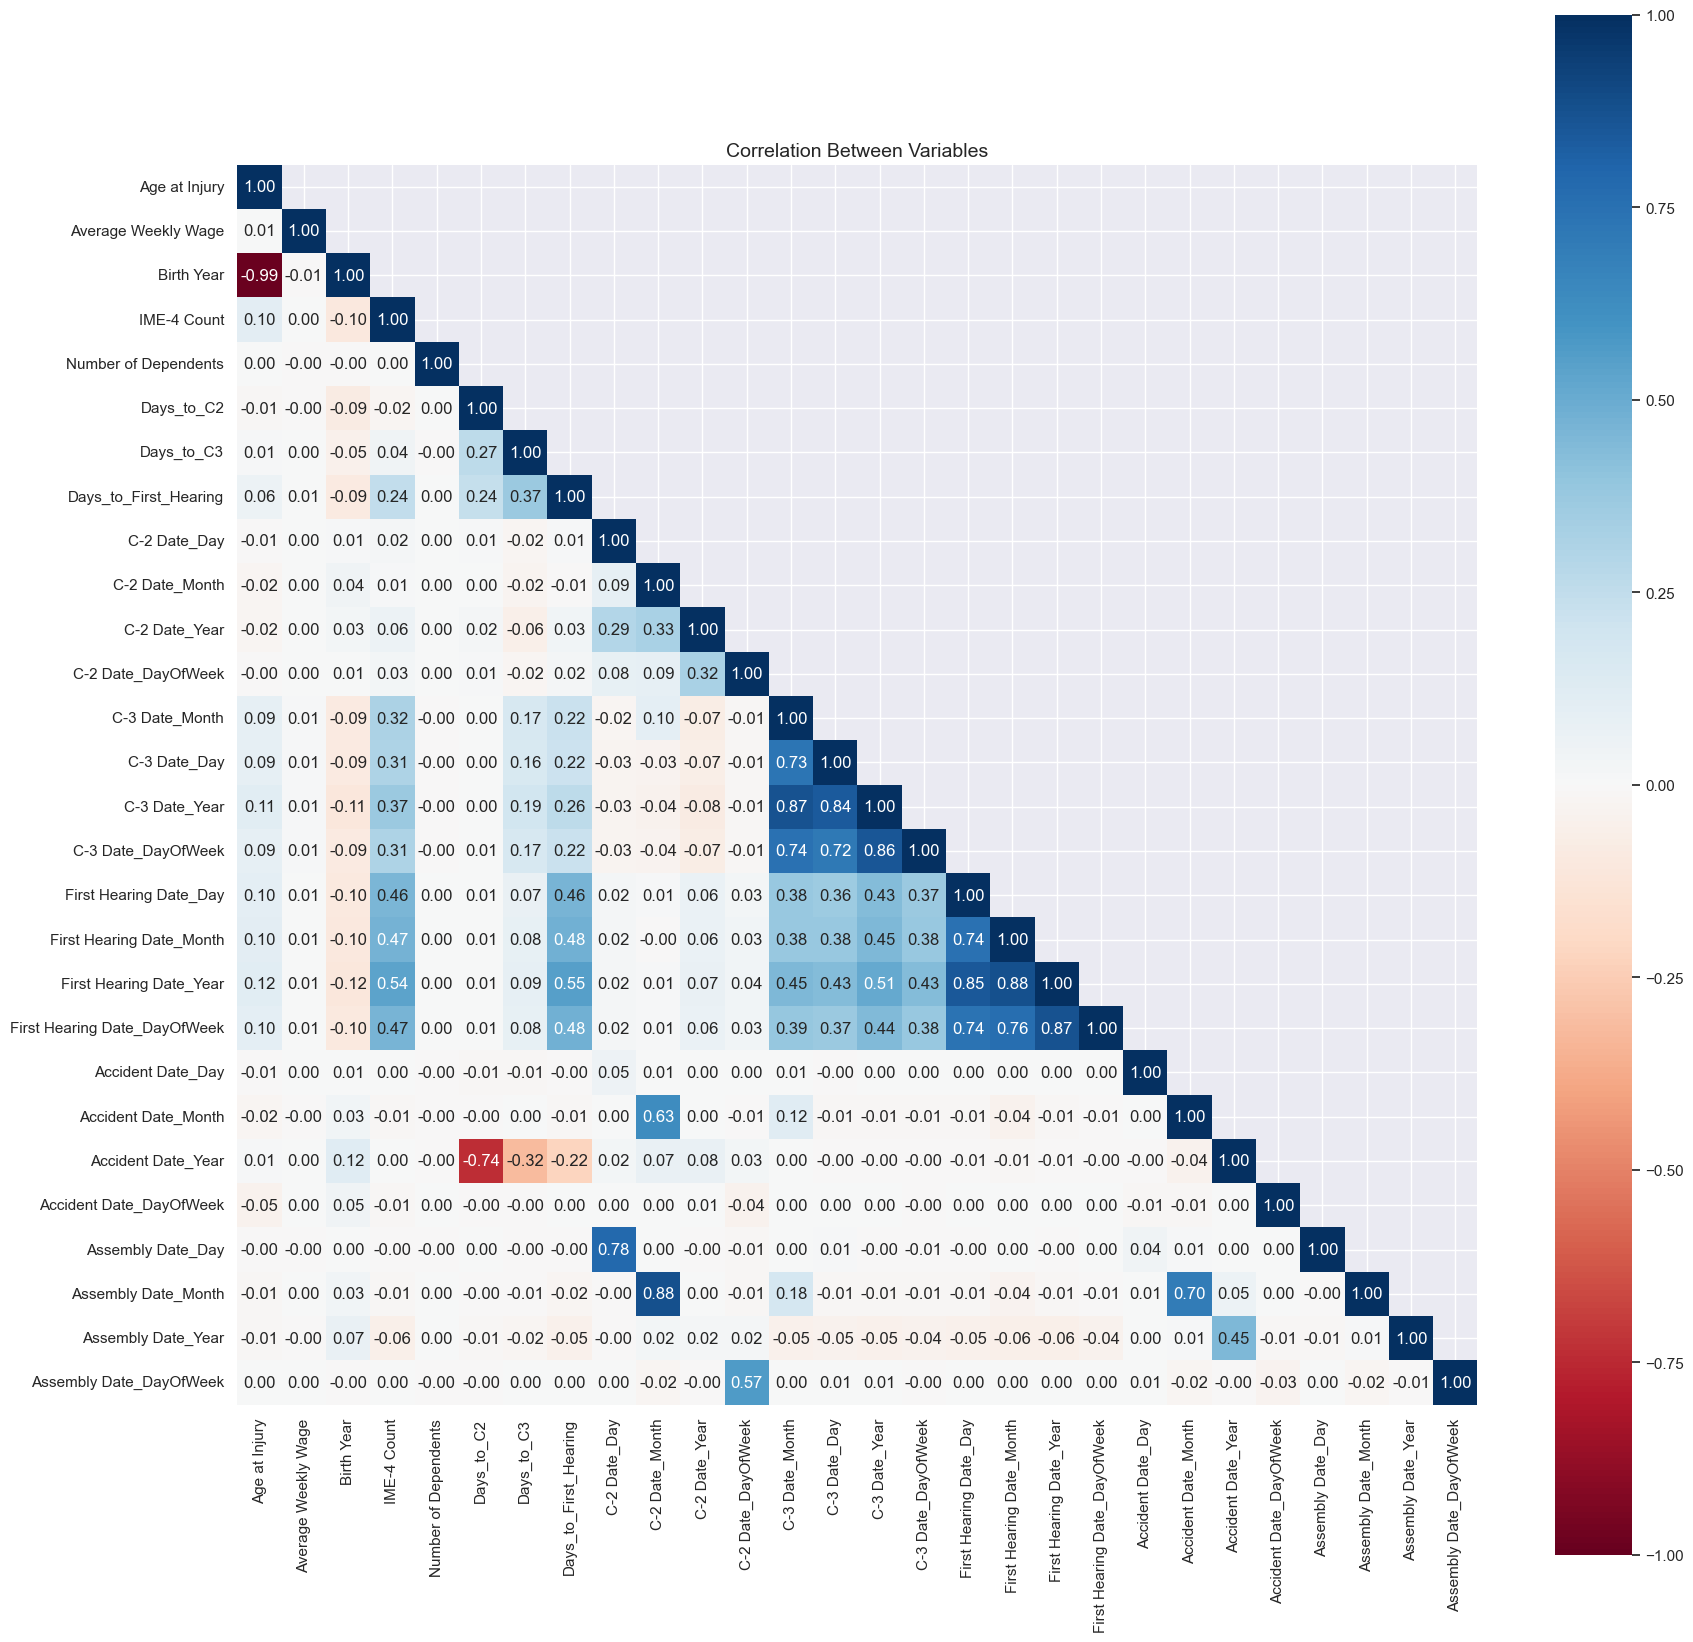

In [24]:
# initial correlation matrix with the respective values
corr_matrix = X_train[numerical_features].corr()

mask = np.tri(*corr_matrix.shape, k=0, dtype=bool)
# Keeps values where mask is True
corr_matrix = corr_matrix.where(mask)

# defines the figure size
fig, ax = plt.subplots(figsize=(20, 20))
# heatmap of the initial correlation matrix
l = sns.heatmap(corr_matrix, square=True, annot=True, fmt=".2f", vmax=1, vmin=-1, cmap='RdBu', ax=ax)
plt.title('Correlation Between Variables', size=14)
plt.show()

High correlation, abose |0.8|

1. Age at Injury and Birth Year → -0.99
2. C-3 Date_Year and C-3 Date_Day → 0.84
3. C-3 Date_Year and C-3 Date_Month → 0.87
4. C-3 Date_Year and C-3 Date_DayOfWeek → 0.86
5. First Hearing Date_Year and First Hearing Date_Day → 0.85
6. First Hearing Date_Year and First Hearing Date_DayOfWeek → 0.87
7. First Hearing Date_Year and  First Hearing Date_Month → 0.88
8. Assembly Date_Month and Assembly Date_Day → 0.88
9. Assembly Date_Month and C-2 Date_Month → 0.88

Might drop Birth Year, C-3 Date_Year, First Hearing Date_Year and Assembly Date_Month


*XGBoosted Feature Importance*

In [25]:
xgb = XGBClassifier(device=device_xgb, max_depth=5, n_estimators= 200).fit(X_train,y_train)

In [26]:
feature_importances_xgb = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

In [27]:
for _, row in feature_importances_xgb.iterrows():
    if row["Importance"] < 0.001:
        print(f"{row['Feature']} -> {row['Importance']}. Drop it")
    elif row['Importance'] < 0.01:
        print(f"{row['Feature']} -> {row['Importance']}. Might drop it")

                                    Feature  Importance
62                            Relative_Wage    0.329987
7                            Known C-2 Date    0.273778
40                Attorney/Representative_Y    0.135398
1                       Average Weekly Wage    0.048383
39         Alternative Dispute Resolution_Y    0.031210
3                               IME-4 Count    0.029298
9                  Known First Hearing Date    0.015863
46                     COVID-19 Indicator_Y    0.013755
42             Carrier Type_3A. SELF PUBLIC    0.009062
45                     Carrier Type_UNKNOWN    0.008579
12                       Accident Date_Year    0.007312
20                            C-2 Date_Year    0.007284
8                            Known C-3 Date    0.006464
32                    Days_to_First_Hearing    0.006114
16                       Assembly Date_Year    0.006022
33                               Days_to_C2    0.004637
44  Carrier Type_5D. SPECIAL FUND - UNKNOWN    0

*Gradient Boosted Feature Importance*

In [28]:
lgb = LGBMClassifier(device=device_lgb,class_weight='balanced',verbose=-1).fit(X_train,y_train)

In [29]:
feature_importances_lgb = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': lgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

In [30]:
for _, row in feature_importances_lgb.iterrows():
    if row["Importance"] < 0.001:
        print(f"{row['Feature']} -> {row['Importance']}. Drop it")
    elif row['Importance'] < 0.01:
        print(f"{row['Feature']} -> {row['Importance']}. Might drop it")

                                    Feature  Importance
60               Enc WCIO Part Of Body Code        1727
32                    Days_to_First_Hearing        1572
33                               Days_to_C2        1537
1                       Average Weekly Wage        1466
59           Enc WCIO Nature of Injury Code        1264
3                               IME-4 Count        1079
58            Enc WCIO Cause of Injury Code        1049
34                               Days_to_C3         911
61                             Enc Zip Code         813
57                        Enc Industry Code         797
55                     Enc County of Injury         776
2                                Birth Year         672
56                        Enc District Name         663
0                             Age at Injury         601
14                        Accident Date_Day         534
30                   First Hearing Date_Day         534
22                             C-2 Date_Day     

*Decision Tree feature importance*

In [31]:
dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, class_weight='balanced').fit(X_train,y_train)

In [32]:
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': dt.feature_importances_
}).sort_values(by='Importance', ascending=False)

In [33]:
for _, row in feature_importance_df.iterrows():
    if row["Importance"] < 0.001:
        print(f"{row['Feature']} -> {row['Importance']}. Drop it")
    elif row['Importance'] < 0.01:
        print(f"{row['Feature']} -> {row['Importance']}. Might drop it")

                                    Feature  Importance
3                               IME-4 Count    0.253620
32                    Days_to_First_Hearing    0.178032
23                       C-2 Date_DayOfWeek    0.152929
59           Enc WCIO Nature of Injury Code    0.112690
62                            Relative_Wage    0.055379
1                       Average Weekly Wage    0.053602
60               Enc WCIO Part Of Body Code    0.038926
26                             C-3 Date_Day    0.030181
33                               Days_to_C2    0.027891
24                            C-3 Date_Year    0.027685
40                Attorney/Representative_Y    0.013707
0                             Age at Injury    0.012934
61                             Enc Zip Code    0.011094
55                     Enc County of Injury    0.006857
34                               Days_to_C3    0.006790
27                       C-3 Date_DayOfWeek    0.006430
46                     COVID-19 Indicator_Y    0

*Logistic Regression RFE*

In [34]:
LR = LogisticRegression()

In [35]:
best_LR = feature_selection_RFE(X_train,y_train,n_features,model=LR)

In [36]:
for col in numerical_features+categorical_features:
    if col not in best_LR:
        print(f"LR : Drop {col}")

LR : Drop C-2 Date_Day
LR : Drop C-2 Date_DayOfWeek
LR : Drop Assembly Date_Day
LR : Drop Alternative Dispute Resolution_U
LR : Drop Enc Zip Code


*Lasso*

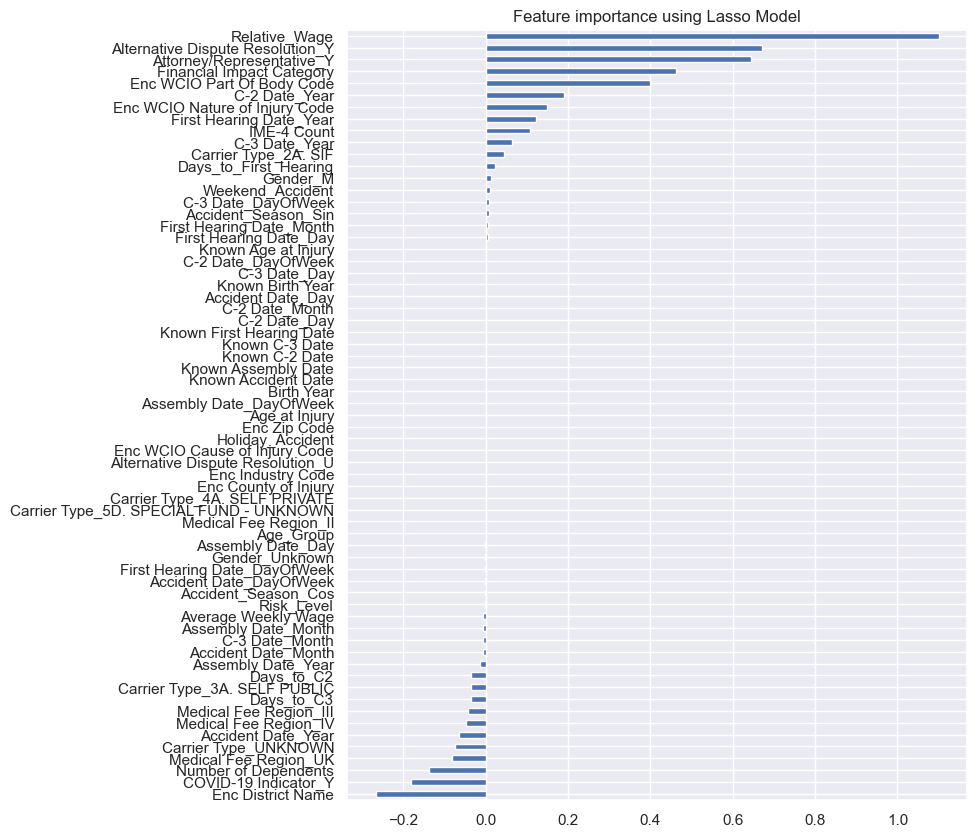

In [37]:
lasso = feature_selection_Lasso(X_train,y_train)

In [38]:
for i in range(len(lasso)):
    if abs(lasso[i]) < 0.01:
        print(f"{X_train.columns[i]} -> {lasso[i]}, Drop it")

Age at Injury -> -0.0
Average Weekly Wage -> -0.005492044013808256
Birth Year -> -0.0
IME-4 Count -> 0.10684087695122634
Number of Dependents -> -0.13822719749660384
Known Accident Date -> 0.0
Known Assembly Date -> 0.0
Known C-2 Date -> 0.0
Known C-3 Date -> 0.0
Known First Hearing Date -> 0.0
Known Age at Injury -> 0.0010673952358852734
Known Birth Year -> 9.914133456169563e-17
Accident Date_Year -> -0.06506610030292362
Accident Date_Month -> -0.007681179446075965
Accident Date_Day -> 0.0
Accident Date_DayOfWeek -> -0.0022823001424706036
Assembly Date_Year -> -0.013883839819235395
Assembly Date_Month -> -0.005787182801457174
Assembly Date_Day -> -0.0005163992989809673
Assembly Date_DayOfWeek -> -0.0
C-2 Date_Year -> 0.1890304368441768
C-2 Date_Month -> 0.0
C-2 Date_Day -> 0.0
C-2 Date_DayOfWeek -> 0.0010150463520057446
C-3 Date_Year -> 0.06441292846848581
C-3 Date_Month -> -0.006055883522275957
C-3 Date_Day -> 0.0006876529329948765
C-3 Date_DayOfWeek -> 0.007581597052351147
First Hea

*Chi-squared test*

In [39]:
for col in categorical_features:
    TestIndependence(X_train[col],y_train,col,alpha=0.05,verbose = False)

Alternative Dispute Resolution_U is NOT an important predictor. (Discard Alternative Dispute Resolution_U from model)
Known Accident Date is NOT an important predictor. (Discard Known Accident Date from model)
Known Assembly Date is NOT an important predictor. (Discard Known Assembly Date from model)
Holiday_Accident is NOT an important predictor. (Discard Holiday_Accident from model)


<hr>

### Numerical Features

| Predictor                        | Spearman | Feature Importance XGB  | Feature Importance LGB | Feature Importance DT | Lasso| RFE Logistic Regression | What to do? (One possible way to "solve") |
|----------------------------------|----------|----------|----------|-----------|-----------|-----------------------|---------------------------------------------|
| Age at Injury                    | Keep     | Keep     | Keep     | Discard   | Discard  |             | Try with and without                        |
| Average Weekly Wage              | Keep     | Keep     | Keep     | Include   | Keep     |            | Include in the model                        |
| Birth Year                       | Discard  | Keep     | Keep     | Discard   | Discard  |            | Try with and without                        |
| IME-4 Count                      | Keep     | Keep     | Keep     | Include   | Keep     |             | Include in the model                        |
| Number of Dependents             | Keep     | Discard  | Keep     | Discard   | Discard  |             | Discard                                     |
| Days_to_C2                       | Keep     | Discard  | Discard  | Discard   | Discard  |             | Discard                                     |
| Days_to_C3                       | Keep     | Discard  | Discard  | Discard   | Discard  |             | Discard                                     |
| Days_to_First_Hearing            | Keep     | Keep     | Keep     | Include   | Keep     |            | Include in the model                        |
| C-2 Date_Day                     | Keep     | Discard  | Discard  | Discard   | Discard  |             | Discard                                     |
| C-2 Date_Month                   | Keep     | Discard  | Discard  | Discard   | Discard  |             | Discard                                     |
| C-2 Date_Year                    | Keep     | Keep     | Keep     | Include   | Keep     |            | Include in the model                        |
| C-2 Date_DayOfWeek               | Keep     | Discard  | Discard  | Discard   | Discard  |             | Discard                                     |
| C-3 Date_Day                     | Keep     | Keep     | Discard  | Include   | Discard  |             | Try with and without                        |
| C-3 Date_Month                   | Keep     | Discard  | Discard  | Discard   | Discard  |             | Discard                                     |
| C-3 Date_Year                    | Discard     | Keep     | Keep     | Include   | Keep  |               | Include in the model                        |
| First Hearing Date_Day           | Keep     | Discard  | Discard  | Discard   | Discard  |             | Discard                                     |
| First Hearing Date_Month         | Keep     | Keep     | Keep     | Discard   | Discard  |             | Try with and without                        |
| First Hearing Date_Year          | Discard     | Keep     | Keep     | Include   | Keep  |               | Include in the model                        |
| First Hearing Date_DayOfWeek     | Keep     | Discard  | Discard  | Discard   | Discard  |             | Discard                                     |
| Accident Date_Day                | Keep     | Discard  | Discard  | Discard   | Discard  |             | Discard                                     |
| Accident Date_Month              | Keep     | Keep     | Keep     | Include   | Keep     |            | Include in the model                        |
| Accident Date_Year               | Keep     | Keep     | Keep     | Include   | Keep     |            | Include in the model                        |
| Assembly Date_Day                | Keep     | Discard  | Discard  | Discard   | Discard  |             | Discard                                     |
| Assembly Date_Month              | Discard     | Discard  | Discard  | Discard   | Discard|               | Discard                                     |
| Assembly Date_Year               | Keep     | Keep     | Keep     | Include   | Keep      |           | Include in the model                        |
| Assembly Date_DayOfWeek          | Keep     | Discard  | Discard  | Discard   | Discard   |           | Discard                                     |

<hr>

### Categorical Features

| Predictor                        | Mutual Info Classif | Feature Importance XGB | Feature Importance LGB | Feature Importance DT | Lasso | RFE Logistic Regression | Chi-Squared Test | What to do? (One possible way to "solve") |
|----------------------------------|----------|------------|------------|------------|------------|------------|------------|------------|
| Alternative Dispute Resolution_U | Keep     | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       |
| Alternative Dispute Resolution_Y | Keep     | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       |
| Attorney/Representative_Y        | Keep     | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       |
| Carrier Type_2A. SIF             | Keep     | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       |
| Carrier Type_3A. SELF PUBLIC     | Keep     | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       |
| Carrier Type_4A. SELF PRIVATE    | Keep     | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       |
| Carrier Type_5D. SPECIA - UNKNOWN| Keep     | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       |
| Carrier Type_UNKNOWN             | Keep     | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       |
| COVID-19 Indicator_Y             | Keep     | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       |
| Enc County of Injury             | Keep     | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       |
| Enc District Name                | Keep     | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       |
| Enc Industry Code                | Keep     | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       |
| Enc WCIO Cause of Injury Code    | Keep     | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       |
| Enc WCIO Nature of Injury Code   | Keep     | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       |
| Enc WCIO Part Of Body Code       | Keep     | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       |
| Enc Zip Code                     | Keep     | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       |
| Financial Impact Category        | Keep     | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       |
| Gender_M                         | Keep     | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       |
| Gender_Unknown                   | Keep     | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       |
| Holiday_Accident                 | Keep     | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       |
| Known Accident Date              | Keep     | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       |
| Known Assembly Date              | Keep     | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       |
| Known C-2 Date                   | Keep     | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       |
| Known C-3 Date                   | Keep     | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       |
| Known First Hearing Date         | Keep     | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       |
| Known Age at Injury              | Keep     | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       |
| Known Birth Year                 | Keep     | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       |
| Medical Fee Region_II            | Keep     | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       |
| Medical Fee Region_III           | Keep     | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       |
| Medical Fee Region_IV            | Keep     | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       |
| Medical Fee Region_UK            | Keep     | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       |
| Relative_Wage                    | Keep     | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       |
| Risk_Level                       | Keep     | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       |
| Weekend_Accident                 | Keep     | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       |
| Age_Group                        | Keep     | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       |
| Accident_Season_Sin              | Keep     | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       |
| Accident_Season_Cos              | Keep     | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       |

<hr>

In [40]:
#test_encoder = LabelEncoder()
#test_encoder.classes_ = target_decoder()